# Cross-correlation of spectra
`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 28 Jul 2022

Adapted from https://specutils.readthedocs.io/en/stable/analysis.html#template-cross-correlation + re-implementation of IRAF FXCOR output

References: 
* continuum normalisation of stellar spectra
* cross-correlation function (CCF) computation
* CCF peak fitting

In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy import units as u
from astropy.modeling import models
from astropy.nddata import StdDevUncertainty
from astropy.table import QTable
import ccdproc as ccdp
import specutils
from specutils.analysis import template_correlate
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_continuum, fit_lines

## Load previously computed data 

In [2]:
# define file names
fname_sci_fw = 'Master_M76_fw_s1d.fit'
fname_rvstd_fw = 'Master_ksi_Ca_fw_s1d.fit'
# load spectra
sci_spec1d = pf.open('reduced/'+fname_sci_fw, ignore_missing_end=True)
rvstd_spec1d = pf.open('reduced/'+fname_rvstd_fw, ignore_missing_end=True)

In [3]:
# Create Spectrum1D objects
sci_S1d = Spectrum1D(
    spectral_axis=sci_spec1d[1].data['wavelength'][::-1]*u.AA,
    flux=sci_spec1d[1].data['flux'][::-1]*u.dimensionless_unscaled,
    uncertainty=StdDevUncertainty(sci_spec1d[1].data['uncertainty'][::-1])
    )
rvstd_S1d = Spectrum1D(
    spectral_axis=rvstd_spec1d[1].data['wavelength'][::-1]*u.AA,
    flux=rvstd_spec1d[1].data['flux'][::-1]*u.dimensionless_unscaled,
    uncertainty=StdDevUncertainty(rvstd_spec1d[1].data['uncertainty'][::-1])
    )

## Fit continuum

<IPython.core.display.Javascript object>


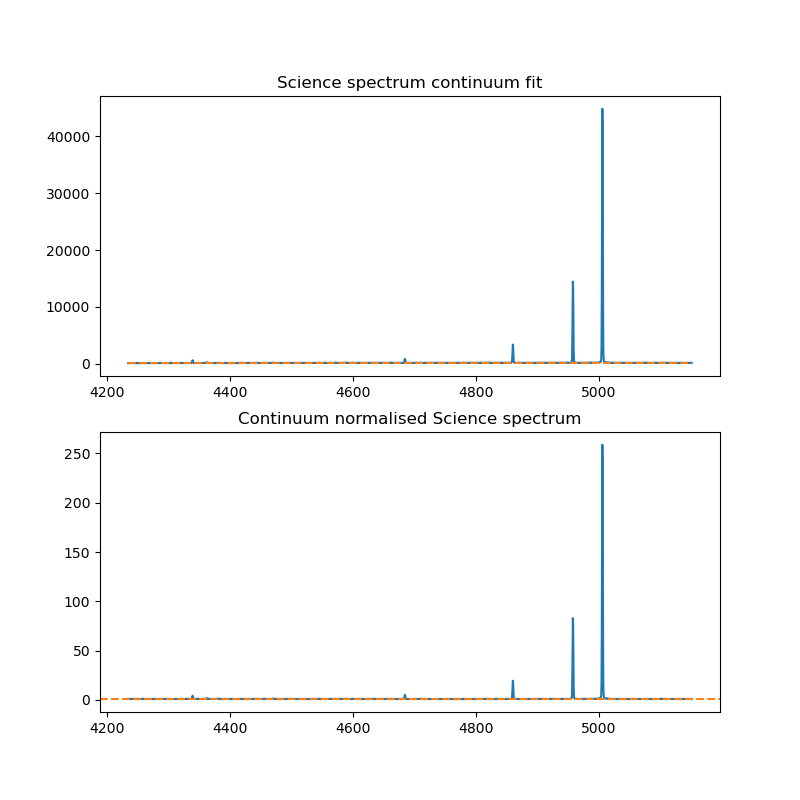

<IPython.core.display.Javascript object>


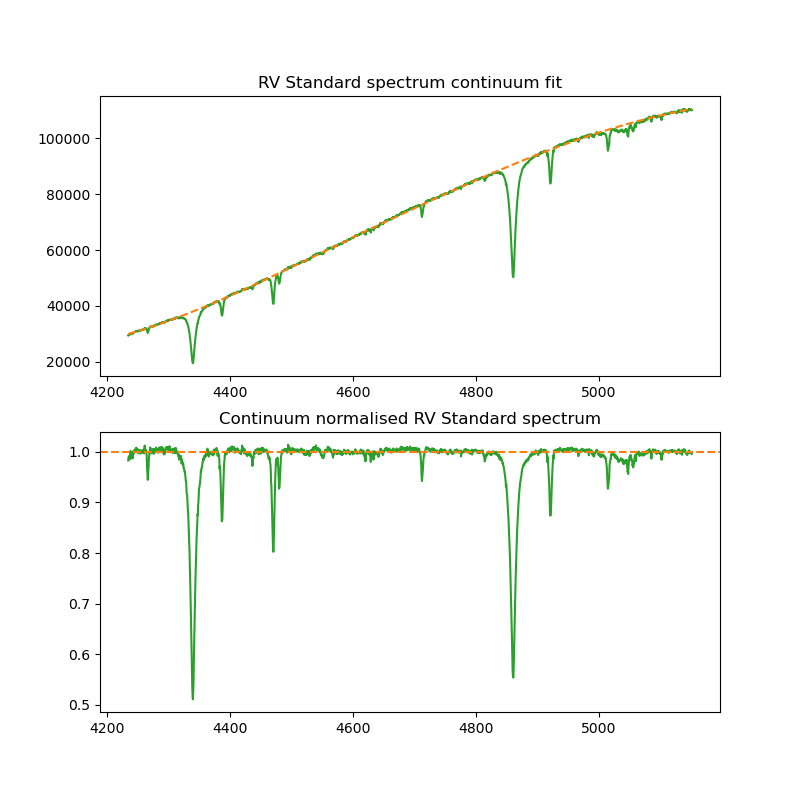

In [4]:
# Define strong line regions to exclude from the fit
excl_reg_M76 = [
    SpectralRegion(4335.*u.AA, 4345.*u.AA),
    SpectralRegion(4680.*u.AA, 4690.*u.AA),
    SpectralRegion(4855.*u.AA, 4865.*u.AA),
    SpectralRegion(4953.*u.AA, 4963.*u.AA),
    SpectralRegion(5000.*u.AA, 5010.*u.AA)
]
excl_reg_ksi_Cas = [
    SpectralRegion(4262.*u.AA, 4272.*u.AA),
    SpectralRegion(4320.*u.AA, 4360.*u.AA),
    SpectralRegion(4380.*u.AA, 4395.*u.AA),
    SpectralRegion(4450.*u.AA, 4500.*u.AA),
    SpectralRegion(4700.*u.AA, 4730.*u.AA),
    SpectralRegion(4830.*u.AA, 4880.*u.AA),
    SpectralRegion(4910.*u.AA, 4930.*u.AA),
    SpectralRegion(4980.*u.AA, 5080.*u.AA)
]
# Fit science spectrum continuum and normalise
cont_fit_sci = fit_continuum(sci_S1d, exclude_regions=excl_reg_M76)
yfit_sci = cont_fit_sci(sci_S1d.spectral_axis)
sci_S1d_c = sci_S1d / yfit_sci 
# Fit RV standard spectrum continuum and normalise
cont_fit_rvstd1 = fit_continuum(rvstd_S1d[0:800], exclude_regions=excl_reg_ksi_Cas)
cont_fit_rvstd2 = fit_continuum(rvstd_S1d[800:2047], exclude_regions=excl_reg_ksi_Cas)
#cont_fit_rvstd = fit_continuum(rvstd_S1d, exclude_regions=excl_reg_ksi_Cas)
yfit_rvstd1 = cont_fit_rvstd1(rvstd_S1d.spectral_axis)
yfit_rvstd2 = cont_fit_rvstd2(rvstd_S1d.spectral_axis)
yfit_rvstd = cont_fit_rvstd1(rvstd_S1d.spectral_axis) #temp
for i in range(len(yfit_rvstd1)):
    if i <= 800:
        yfit_rvstd[i] = yfit_rvstd1[i]
    else:
        yfit_rvstd[i] = yfit_rvstd2[i]
rvstd_S1d_c = rvstd_S1d / yfit_rvstd 


# Plot sci spectrum + continuum fit and normalised spectrum
%matplotlib notebook
fig = plt.figure(1, figsize=(8,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(sci_S1d.spectral_axis, sci_S1d.flux, c='tab:blue')
ax1.plot(sci_S1d.spectral_axis, yfit_sci, c='tab:orange', ls='--')
ax1.set_title('Science spectrum continuum fit')
#
ax2 = fig.add_subplot(212)
ax2.plot(sci_S1d_c.spectral_axis, sci_S1d_c.flux, c='tab:blue')
ax2.axhline(1.0, c='tab:orange', ls='--')
ax2.set_title('Continuum normalised Science spectrum')
#
# Plot rv std spectrum + continuum fit and normalised spectrum
fig = plt.figure(2, figsize=(8,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(rvstd_S1d.spectral_axis, rvstd_S1d.flux, c='tab:green')
ax1.plot(rvstd_S1d.spectral_axis, yfit_rvstd, c='tab:orange', ls='--')
ax1.set_title('RV Standard spectrum continuum fit')
#
ax2 = fig.add_subplot(212)
ax2.plot(rvstd_S1d_c.spectral_axis, rvstd_S1d_c.flux, c='tab:green')
ax2.axhline(1.0, c='tab:orange', ls='--')
ax2.set_title('Continuum normalised RV Standard spectrum')
#

plt.show()


## Compute CCF

In [5]:
# # subtract median before computing CCF --> critical step!
# sci_S1d_c -= np.median(sci_S1d_c.flux.value)*sci_S1d_c.flux.unit
# rvstd_S1d_c -= np.median(rvstd_S1d_c.flux.value)*rvstd_S1d_c.flux.unit
# # tweak uncertainties
# sci_S1d_c.uncertainty = StdDevUncertainty(0.01*np.ones_like(sci_S1d_c.flux))
# rvstd_S1d_c.uncertainty = StdDevUncertainty(0.01*np.ones_like(rvstd_S1d_c.flux))

C:\Users\adria\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:2532: RuntimeWarning: invalid value encountered in true_divide
  norm_distances.append((x - grid[i]) /


CCF velocity bin (min, median, max): 22.03 26.28 31.35 km / s


C:\Users\adria\anaconda3\lib\site-packages\astropy\units\quantity.py:611: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<IPython.core.display.Javascript object>


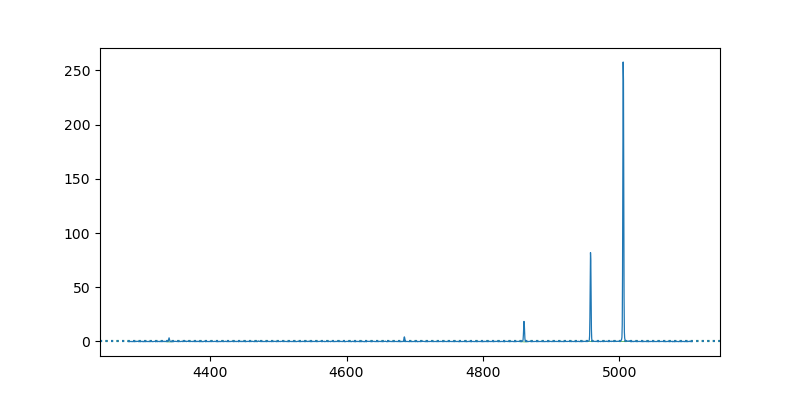

In [6]:
# # actual CCF computation
# ## defines min/max indices for CCF computation
# imin=100
# imax=-100
# corr, lag = template_correlate(sci_S1d_c[imin:imax], rvstd_S1d_c[imin:imax])
# lag_bin = [lag[i+1].value-lag[i].value for i in range(len(lag)-1)]
# med_lag_bin = np.median(lag_bin)
# print("CCF velocity bin (min, median, max): %.2f %.2f %.2f %s"  % 
#       (np.min(lag_bin), med_lag_bin, np.max(lag_bin), lag.unit))

# # plot science and RV standard spectra
# plt.figure(figsize=(8,4))
# plt.plot(rvstd_S1d_c.spectral_axis[imin:imax], rvstd_S1d_c.flux[imin:imax], c='tab:green', lw=.5)
# plt.axhline(np.median(rvstd_S1d_c.flux.value), ls=':', c='tab:green')
# plt.plot(sci_S1d_c.spectral_axis[imin:imax], sci_S1d_c.flux[imin:imax], c='tab:blue', lw=.9)
# plt.axhline(np.median(sci_S1d_c.flux.value), ls=':', c='tab:blue')
# plt.show()

Fit on 75 points [-1049.44,894.92] km / s

CCF fit RMS=9.6361

Tonry & Davis (1979) R-values: -23.190 -21.312

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=-19.03105349 , mean=-123.82893531 km / s, stddev=0. km / s)>

    [1]: <Gaussian1D(amplitude=-16.39353574 , mean=276.81498363 km / s, stddev=0. km / s)>

    [2]: <Const1D(amplitude=-13.54335596 )>
Parameters:
        amplitude_0            mean_0       ...     amplitude_2    
                               km / s       ...                    
    ------------------- ------------------- ... -------------------
    -19.031053486555656 -123.82893530660368 ... -13.543355956304664


<IPython.core.display.Javascript object>


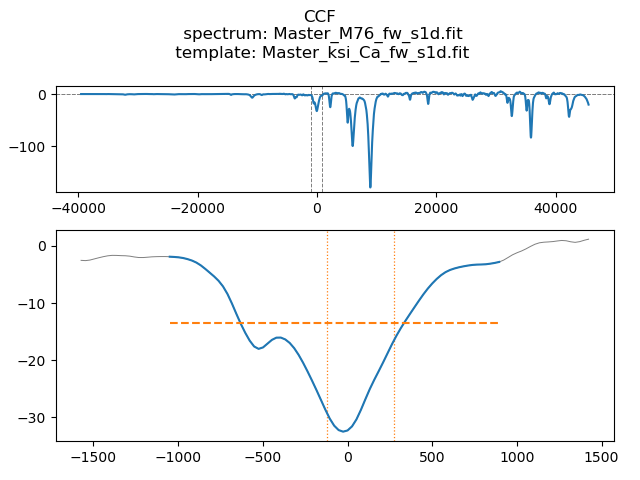

In [7]:
# # fit CCF peak
# ## define window around central bin v=0 km/s
# i0 = int(len(lag)/2)
# ifit_min = i0 - 40
# ifit_max = i0 + 34
# print("Fit on %2d points [%.2f,%.2f] %s\n" % (ifit_max-ifit_min+1, lag[ifit_min].value, lag[ifit_max].value, lag.unit))

# # Set fitting function
# ## tweaking the initial model parameters may be necessary
# g1_init = models.Gaussian1D(amplitude=0.5*u.dimensionless_unscaled, mean=-100*u.Unit('km/s'), stddev=2.*med_lag_bin*u.Unit('km/s'))
# g2_init = models.Gaussian1D(amplitude=0.5*u.dimensionless_unscaled, mean=100*u.Unit('km/s'), stddev=2.*med_lag_bin*u.Unit('km/s'))
# const_init = models.Const1D(amplitude=0.3*u.dimensionless_unscaled)
# corr_S1d = Spectrum1D(
#     spectral_axis=lag[ifit_min:ifit_max+1],
#     flux=corr[ifit_min:ifit_max+1]
#     )
# #g_fit = fit_lines(corr_S1d, g1_init+const_init) # gaussian + cte
# g_fit = fit_lines(corr_S1d, g1_init+g2_init+const_init) # bi-gaussian + cte
# ccf_fit = g_fit(lag[ifit_min:ifit_max+1])

# # print fit results
# ccf_rms = np.sqrt(np.mean((ccf_fit-corr[ifit_min:ifit_max+1])**2))
# print("CCF fit RMS=%.4f\n" % ccf_rms)
# ## Tonry & Davis (1979) r' value
# ### single gaussian
# #sig_a = np.std(corr[0:ifit_min-20])
# #R1 = (g_fit[0].amplitude.value + g_fit[1].amplitude.value) / (np.sqrt(2.)*sig_a)
# #print("Tonry & Davis (1979) R-values: %.3f\n" % R1)
# ## Tonry & Davis (1979) r' value
# ### bi-gaussian
# sig_a = np.std(corr[0:ifit_min-20])
# R1 = (g_fit[0].amplitude.value + g_fit[2].amplitude.value) / (np.sqrt(2.)*sig_a)
# R2 = (g_fit[1].amplitude.value + g_fit[2].amplitude.value)/ (np.sqrt(2.)*sig_a)
# print("Tonry & Davis (1979) R-values: %.3f %.3f\n" % (R1, R2))
# #
# print(g_fit)


# # plot full CCF (only edges are trimmed)
# fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]})
# fig.tight_layout()
# ax[0].axhline(0., ls='--', c='tab:gray', lw=.7)
# ax[0].axhline(sig_a, ls=':', c='tab:gray', lw=.7)
# ax[0].axvline(lag[ifit_min].value, ls='--', c='tab:gray', lw=.7)
# ax[0].axvline(lag[ifit_max].value, ls='--', c='tab:gray', lw=.7)
# ax[0].plot(lag[400:-400], corr[400:-400], c='tab:blue')
# # plot CCF on the fit area + actual fit
# ax[1].axvline(g_fit[0].mean.value, c='tab:orange', ls=':', lw=.9)
# ax[1].axvline(g_fit[1].mean.value, c='tab:orange', ls=':', lw=.9)
# ax[1].plot(lag[ifit_min-20:ifit_max+21], corr[ifit_min-20:ifit_max+21], c='tab:gray', lw=.7)
# ax[1].plot(lag[ifit_min:ifit_max+1], corr[ifit_min:ifit_max+1], c='tab:blue')
# ax[1].plot(lag[ifit_min:ifit_max+1], ccf_fit, c='tab:orange', ls='--')
# #plt.plot(lag, y_fit, c='tab:orange', ls='--')
# #plt.plot(lag, g1_init(lag), c='tab:green', ls=':'
# fig.suptitle("CCF\n spectrum: %s\n template: %s" % (fname_sci_fw, fname_rvstd_fw))
# fig.subplots_adjust(top=0.82)
# plt.show()

<IPython.core.display.Javascript object>


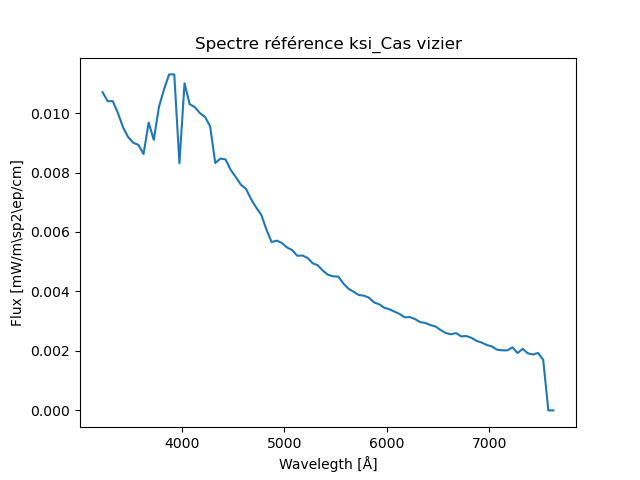

In [8]:
#On ouvre le fichier

fig, ax = plt.subplots(1, 1)
vizier_texte=open("ksi_Cas_calib_flux", "r")
vizier=np.loadtxt(vizier_texte).T
vizier[0] *= 10
ax.plot(vizier[0],vizier[1])
ax.set_xlabel("Wavelegth [Å]")
ax.set_ylabel("Flux [mW/m\sp2\ep/cm]")
ax.set_title("Spectre référence ksi_Cas vizier")
plt.show()

<IPython.core.display.Javascript object>


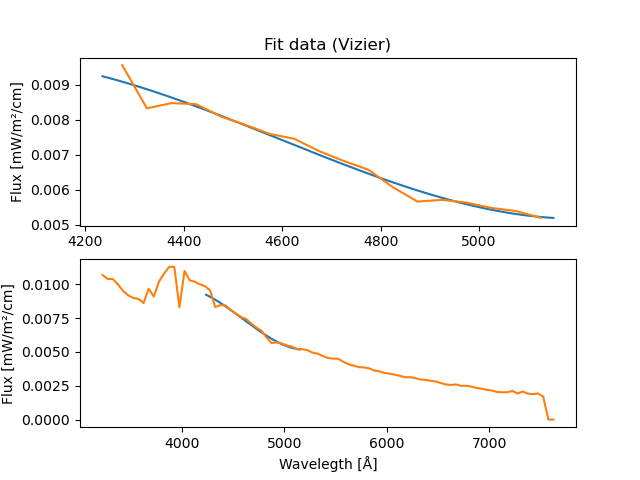

In [9]:
#fit courbe vizier:

fig, ax = plt.subplots(2, 1)
vizier_limit=[]
for k,i in enumerate(vizier[0]):
    if i >= rvstd_S1d.spectral_axis[0].value and i <= rvstd_S1d.spectral_axis[2047].value:
        vizier_limit.append([i,vizier[1][k]])
    elif i > rvstd_S1d.spectral_axis[2047].value:
        break
vizier_limit=np.array(vizier_limit).T
f_cal_coeff=np.polyfit(vizier_limit[0],vizier_limit[1],3)
vizier_fit=[]
for x in rvstd_S1d.spectral_axis.value:
    vizier_fit.append(np.poly1d(f_cal_coeff)([x])[0])

ax[0].plot(rvstd_S1d.spectral_axis.value,vizier_fit)
ax[0].plot(vizier_limit[0],vizier_limit[1])
ax[1].plot(rvstd_S1d.spectral_axis.value,vizier_fit)
ax[1].plot(vizier[0],vizier[1])
ax[0].set_ylabel("Flux [mW/m²/cm]")
ax[0].set_title("Fit data (Vizier)")
ax[1].set_xlabel("Wavelegth [Å]")
ax[1].set_ylabel("Flux [mW/m²/cm]")
plt.show()

<IPython.core.display.Javascript object>


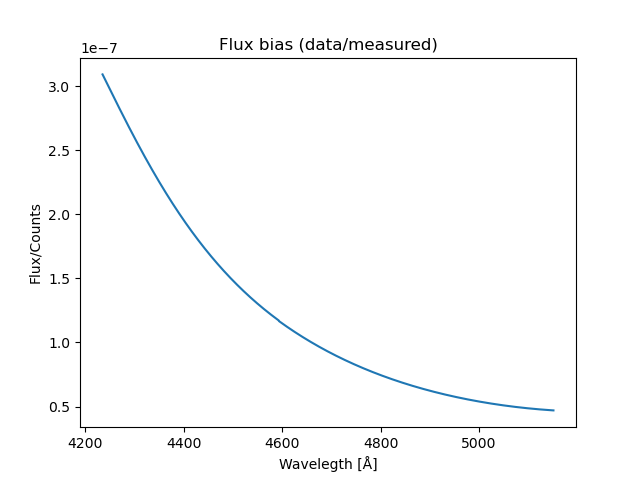

In [10]:
#Définition du ratio pour corriger le flux

flux_ratio = vizier_fit/yfit_rvstd
fig, ax = plt.subplots(1, 1)
ax.plot(rvstd_S1d.spectral_axis,flux_ratio)
ax.set_xlabel("Wavelegth [Å]")
ax.set_ylabel("Flux/Counts")
ax.set_title("Flux bias (data/measured)")
plt.show()

<IPython.core.display.Javascript object>


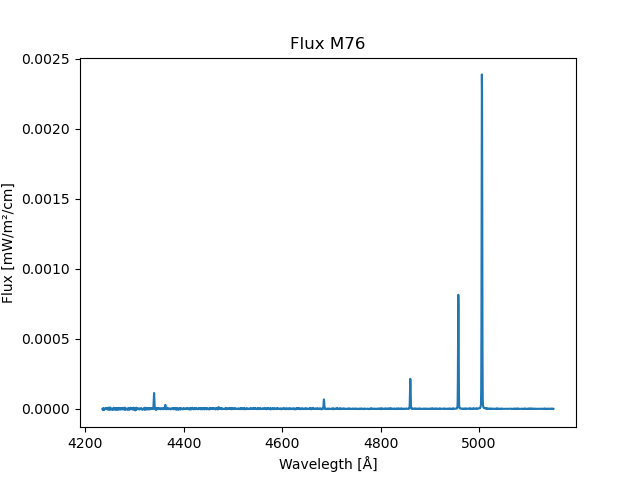

In [11]:
#Correction en flux de M76
M76_spectrum = Spectrum1D(
    spectral_axis=sci_S1d.spectral_axis,
    flux=flux_ratio*(sci_S1d.flux-yfit_sci),
    uncertainty=StdDevUncertainty(sci_spec1d[1].data['uncertainty'][::-1]*flux_ratio)
    )
fig, ax = plt.subplots(1, 1)

ax.plot(M76_spectrum.spectral_axis,M76_spectrum.flux)
ax.set_xlabel("Wavelegth [Å]")
ax.set_ylabel("Flux [mW/m²/cm]")
ax.set_title("Flux M76")
plt.show()

SAVE SPECTRA

In [12]:
# Save science spectrum as a fits file
## primary HDU contains header from parent file
sci_s1d = ccdp.CCDData.read('reduced/' + 'Master_M76_s1d.fit')
fname_sci_M76='M76_Spectrum.fit'
M76_uncertainty=copy.deepcopy(M76_spectrum.uncertainty)
prihdu_M76 = pf.PrimaryHDU(header=sci_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
M76_tab = QTable([M76_spectrum.spectral_axis, M76_spectrum.flux*u.mW/u.m/u.m/u.cm, M76_uncertainty.array*u.mW/u.m/u.m/u.cm], names=('wavelength', 'flux', 'uncertainty'))
M76_hdu = pf.table_to_hdu(M76_tab)
M76_hdul = pf.HDUList([prihdu_M76, M76_hdu])
bname, ext = os.path.splitext(fname_sci_M76)
M76_hdul.writeto('reduced/'+fname_sci_M76, overwrite=True)
print(fname_sci_M76, 'saved')
## alternatively one can just save the QTable but original header info is lost

M76_Spectrum.fit saved


<IPython.core.display.Javascript object>


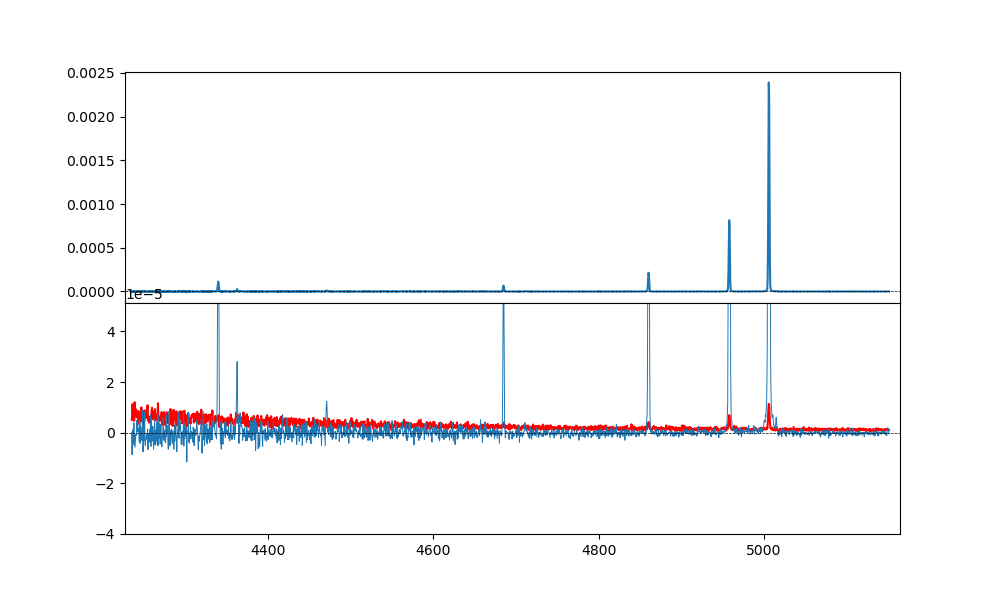

In [13]:
# Plot the spectrum and its uncertainty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0)
# science spectrum
ax1.plot(M76_tab['wavelength'], M76_tab['flux'])
ax1.axhline(0., ls='--', c='k', lw=.5)
# associated uncertainty'
ax2.plot(M76_tab['wavelength'], M76_tab['uncertainty'],c="red")
ax2.plot(M76_tab['wavelength'], M76_tab['flux'], lw=0.7)
ax2.axhline(0., ls='--', c='k', lw=.5)
#ax2.set_xlim(0,1.e3)
plt.show()